In [1]:
#import libraries
import streamlit as st

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import time, date, datetime

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

## A. Data Wrangling

**Raw CFU** file is a template. To write a function:
- skiprows=2
- key: 'Batch' col
- features: [Sample description],'Storage form','Temperature-Celsius','T0','Date','CFU/mL','CFU/g','CV','Water Acitivty' cols
- remove rows with NaN in 'Batch' col
- Change 'Batch' col to 'FD Run ID'

- Change to datetime for "Date, T0"
- Change to float/number for "CFU/mL, CFU/g, CV": fix DIV/0 to NaN

In [2]:
# Import the dataset
rawcfu_df = pd.read_csv(filepath_or_buffer="Data files/Pivot_CFUs_Test.csv")
rawcfu_df.head()

,"Sparkle PIVOT Sample CFU plating data recording sheet. Manually enter your data in columns marked with a ⭐ (optional: †) and the other columns should auto-calculate appropriately. The data are sortable, and can be filtered using the dropdowns in each column.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,⭐,⭐,⭐,⭐,†,⭐,†,⭐,NaN,⭐,...,⭐,⭐,†,NaN,NaN,NaN,NaN,NaN,NaN,†
1,Batch,Sample Description,Storage form,Temperature-Celsius,Logs,No. Reps,Extra,grams,mL,Who,...,R1,R2,R3,CFU/mL,SD CFU/mL,CFU/g,SD CFU/g,CV,Water Activity,Remark/AW
2,FDL-105B-T05,NaN,Pellet,NaN,"6, 7",2,NaN,0.3,5.7,EC,...,43,64,NaN,2.14E+09,5.94E+08,4.07E+10,1.13E+10,27.80%,NaN,NaN
3,FDL-105B-T06,NaN,Pellet,NaN,"6, 7",2,NaN,0.3,5.7,EC,...,91,85,NaN,3.52E+09,1.70E+08,6.69E+10,3.22E+09,4.80%,NaN,NaN
4,FDL-105B-T07,NaN,Pellet,NaN,"6, 7",2,NaN,0.3,5.7,EC,...,40,39,NaN,1.58E+10,2.83E+08,3.00E+11,5.37E+09,1.80%,NaN,NaN


In [3]:
# replace the colmns with the values of the second row
rawcfu_df.columns = rawcfu_df.iloc[1]

# remove the first and second rows
rawcfu_df = rawcfu_df.iloc[2:]

# reset index
rawcfu_df = rawcfu_df.reset_index()

# keep relevant cols
rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature-Celsius',
                       'T0','Date','CFU/mL','CFU/g','CV','Water Activity']]

rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity
0,FDL-105B-T05,NaN,Pellet,NaN,1/3/23,1/3/23,2.14E+09,4.07E+10,27.80%,NaN
1,FDL-105B-T06,NaN,Pellet,NaN,1/3/23,1/3/23,3.52E+09,6.69E+10,4.80%,NaN
2,FDL-105B-T07,NaN,Pellet,NaN,1/3/23,1/3/23,1.58E+10,3.00E+11,1.80%,NaN
3,FDL-105B-T09,NaN,Pellet,NaN,1/3/23,1/3/23,3.10E+09,5.89E+10,13.70%,NaN
4,FDL-105B-T10,NaN,Pellet,NaN,1/3/23,1/3/23,3.36E+10,6.38E+11,10.10%,NaN


In [4]:
rawcfu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Batch                401 non-null    object
 1   Sample Description   154 non-null    object
 2   Storage form         157 non-null    object
 3   Temperature-Celsius  128 non-null    object
 4   T0                   401 non-null    object
 5   Date                 401 non-null    object
 6   CFU/mL               405 non-null    object
 7   CFU/g                405 non-null    object
 8   CV                   405 non-null    object
 9   Water Activity       101 non-null    object
dtypes: object(10)
memory usage: 31.8+ KB


<Axes: xlabel='1'>

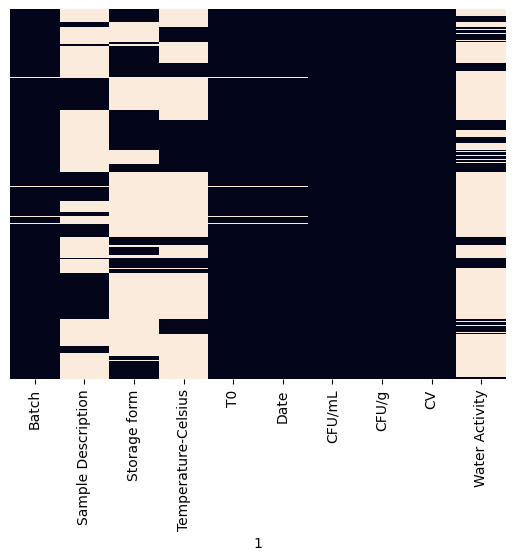

In [5]:
# check NaN values
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)

(401, 10)

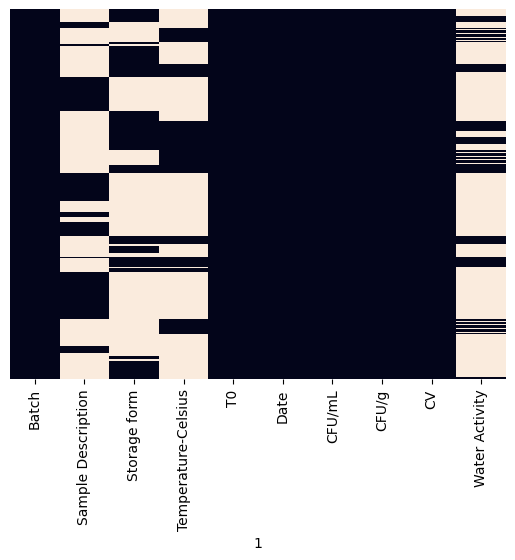

In [6]:
# remove rows with NaN in 'Batch" col
rawcfu_df.dropna(subset=['Batch'],inplace=True)
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)
rawcfu_df.shape

# NaN in CFU/mL or CFU/g indicate either the samples in liq or sol form

In [7]:
rawcfu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 404
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Batch                401 non-null    object
 1   Sample Description   154 non-null    object
 2   Storage form         157 non-null    object
 3   Temperature-Celsius  128 non-null    object
 4   T0                   401 non-null    object
 5   Date                 401 non-null    object
 6   CFU/mL               401 non-null    object
 7   CFU/g                401 non-null    object
 8   CV                   401 non-null    object
 9   Water Activity       101 non-null    object
dtypes: object(10)
memory usage: 34.5+ KB


In [8]:
# convert to datetime for T0 and Date
rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")

In [9]:
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.14E+09,4.07E+10,27.80%,NaN
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.52E+09,6.69E+10,4.80%,NaN
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.58E+10,3.00E+11,1.80%,NaN
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.10E+09,5.89E+10,13.70%,NaN
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.36E+10,6.38E+11,10.10%,NaN


In [10]:
# calculate the time point of plating
## the difference 'Date'-'T0' is a 'timedelta'
rawcfu_df['Time point (day)'] = (rawcfu_df['Date']-rawcfu_df['T0']).apply(lambda x: x.days)
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.14E+09,4.07E+10,27.80%,NaN,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.52E+09,6.69E+10,4.80%,NaN,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.58E+10,3.00E+11,1.80%,NaN,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.10E+09,5.89E+10,13.70%,NaN,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.36E+10,6.38E+11,10.10%,NaN,0


In [11]:
# calculate time point in week
## cant' call .days or .week on timedelta. 
## So, I have to convert each dat to week of the year first before calculating the difference
to_week = rawcfu_df[['T0','Date']]

In [12]:
rawcfu_df['Date'].iloc[0].week - rawcfu_df['T0'].iloc[0].week

0

In [13]:
to_week.columns

Index(['T0', 'Date'], dtype='object', name=1)

In [14]:
for i in to_week.columns:
    to_week[i] = to_week[i].apply(lambda x:x.week)

In [15]:
rawcfu_df['Time point (week)'] = to_week['Date'] - to_week['T0']

In [16]:
rawcfu_df.head()

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.14E+09,4.07E+10,27.80%,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.52E+09,6.69E+10,4.80%,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.58E+10,3.00E+11,1.80%,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.10E+09,5.89E+10,13.70%,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.36E+10,6.38E+11,10.10%,NaN,0,0


In [17]:
# Change data type of CFU/mL 
rawcfu_df['CFU/mL'] = rawcfu_df['CFU/mL'].astype(float)

In [18]:
# invalid values (not scientific) in CFU/g col
rawcfu_df.loc[rawcfu_df['CFU/g'] == '#DIV/0!'].index

Int64Index([ 75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
            ...
            330, 331, 332, 333, 334, 335, 336, 337, 338, 339],
           dtype='int64', length=139)

In [19]:
# replace invalid values with NaN
rawcfu_df['CFU/g'] = rawcfu_df['CFU/g'].replace('#DIV/0!', np.NaN)

In [20]:
# Change data type of CFU/g to float
rawcfu_df['CFU/g'] = rawcfu_df['CFU/g'].astype(float)

In [21]:
# Change data type of CV to float
## convert each value to float without the % sign and ignore invalid values
for idx, row in rawcfu_df.iterrows():
    try:
        rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
    except Exception as e:
        pass

In [22]:
## replace invalid values with NaN
rawcfu_df['CV'] = rawcfu_df['CV'].replace('#DIV/0!', np.NaN)

In [23]:
rawcfu_df

1,Batch,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV,Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
400,EDKOKO02222302,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,3.560000e+08,6.760000e+09,13.2,NaN,0,0
401,FDL-105K-T42,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,4.030000e+08,7.650000e+09,10.3,NaN,0,0
402,FDL-105K-T44,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,1.130000e+08,2.150000e+09,1.7,NaN,0,0
403,FDL-105EF-T24 TMC1,NaN,Bulked powder,NaN,2023-04-07,2023-04-07,1.570000e+09,2.990000e+10,4.8,0.298,0,0


<Axes: xlabel='1'>

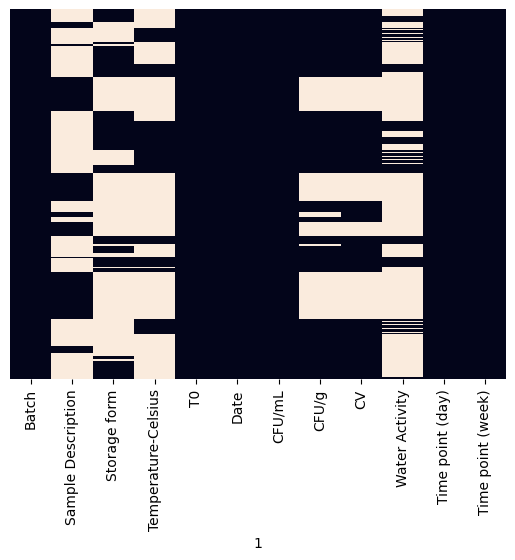

In [24]:
sns.heatmap(rawcfu_df.isnull(), yticklabels=False, cbar=False)

In [25]:
rawcfu_df.info()
# Keep Temp in str for visualization purpose

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 404
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Batch                401 non-null    object        
 1   Sample Description   154 non-null    object        
 2   Storage form         157 non-null    object        
 3   Temperature-Celsius  128 non-null    object        
 4   T0                   401 non-null    datetime64[ns]
 5   Date                 401 non-null    datetime64[ns]
 6   CFU/mL               401 non-null    float64       
 7   CFU/g                262 non-null    float64       
 8   CV                   269 non-null    float64       
 9   Water Activity       101 non-null    object        
 10  Time point (day)     401 non-null    int64         
 11  Time point (week)    401 non-null    int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 56.9+ KB


In [26]:
# Change Water Activity to float
rawcfu_df['Water Activity'] = rawcfu_df['Water Activity'].astype(float)

In [27]:
# Change col names
rawcfu_df.rename(columns={'Batch':'FD Run ID', 'CV':'CV (%)'}, inplace=True)
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature-Celsius,T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0


In [28]:
rawcfu_df.rename(columns={'Temperature-Celsius':'Temperature (C)'}, inplace=True)
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0


### Data cleaning steps

In [2]:
# Import the dataset
rawcfu_df = pd.read_csv(filepath_or_buffer="Data files/Pivot_CFUs_Test.csv")

In [3]:
# replace the colmns with the values of the second row
rawcfu_df.columns = rawcfu_df.iloc[1]
# remove the first and second rows
rawcfu_df = rawcfu_df.iloc[2:]
# reset index
rawcfu_df = rawcfu_df.reset_index()
# keep relevant cols
rawcfu_df = rawcfu_df[['Batch','Sample Description','Storage form','Temperature (C)',
                       'T0','Date','CFU/mL','CFU/g','CV','Water Activity']]
# remove rows with NaN in 'Batch" col
rawcfu_df.dropna(subset=['Batch'],inplace=True)


# convert to datetime for T0 and Date
rawcfu_df[['T0','Date']] = rawcfu_df[['T0','Date']].apply(pd.to_datetime, format="%m/%d/%y")

# calculate the time point of plating
## by days
rawcfu_df['Time point (day)'] = (rawcfu_df['Date']-rawcfu_df['T0']).apply(lambda x: x.days)
## by weeks
to_week = rawcfu_df[['T0','Date']]
for i in to_week.columns:
    to_week[i] = to_week[i].apply(lambda x:x.week)
rawcfu_df['Time point (week)'] = to_week['Date'] - to_week['T0']    

# remove percentage sign for CV values while ignoring invalid values
for idx, row in rawcfu_df.iterrows():
    try:
        rawcfu_df.loc[idx, "CV"] = float(row['CV'].split("%")[0])
    except Exception as e:
        pass

# handle invalid values and change to float
to_float = rawcfu_df[['CFU/mL','CFU/g','CV','Water Activity']]
for col in to_float.columns:
    rawcfu_df[col] = rawcfu_df[col].replace('#DIV/0!', np.NaN)
    rawcfu_df[col] = rawcfu_df[col].astype(float)
    
    
# Change col names
rawcfu_df.rename(columns={'Batch':'FD Run ID', 'Temperature-Celsius':'Temperature (C)', 'CV':'CV (%)'}, inplace=True)

## B. Data Processing

One sample can be in different storage form: bulk powder, pellet. Each will have a unique 'FD Run ID'
- **ISSUE: Naming for unique ID**
    Each 'FD Run ID' is not unique because:
    - one sample is submitted to different temperatures
    - one sample is stored in different form
- Tranpose the CFU of each sample by Timepoint (week) (axis =1)
- Join new CFU data for each time point, axis =1

In [29]:
rawcfu_df.head()

1,FD Run ID,Sample Description,Storage form,Temperature (C),T0,Date,CFU/mL,CFU/g,CV (%),Water Activity,Time point (day),Time point (week)
0,FDL-105B-T05,NaN,Pellet,NaN,2023-01-03,2023-01-03,2.140000e+09,4.070000e+10,27.8,NaN,0,0
1,FDL-105B-T06,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.520000e+09,6.690000e+10,4.8,NaN,0,0
2,FDL-105B-T07,NaN,Pellet,NaN,2023-01-03,2023-01-03,1.580000e+10,3.000000e+11,1.8,NaN,0,0
3,FDL-105B-T09,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.100000e+09,5.890000e+10,13.7,NaN,0,0
4,FDL-105B-T10,NaN,Pellet,NaN,2023-01-03,2023-01-03,3.360000e+10,6.380000e+11,10.1,NaN,0,0


In [30]:
rawcfu_df.shape

(401, 12)

<Axes: xlabel='Time point (week)', ylabel='Density'>

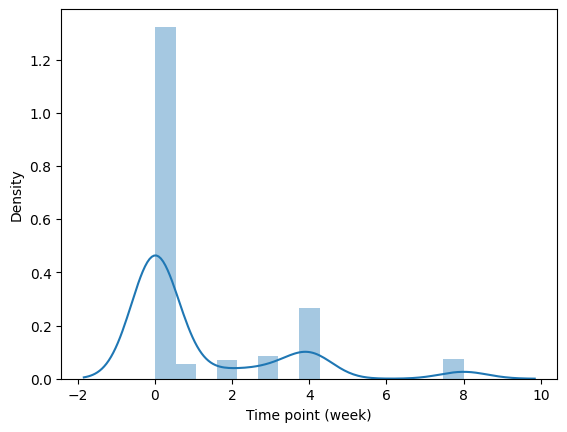

In [32]:
sns.distplot(rawcfu_df['Time point (week)'])